In [0]:
#@title Imports and defaults
%matplotlib inline

from __future__ import absolute_import, division, print_function
from google3.pyglib import gfile
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import time

mpl.style.use("classic")
mpl.rcParams["figure.figsize"] = [5, 3]

mpl.rcParams["axes.linewidth"] = 0.75
mpl.rcParams["grid.linewidth"] = 0.75
mpl.rcParams["lines.linewidth"] = 0.75
mpl.rcParams["patch.linewidth"] = 0.75
mpl.rcParams["xtick.major.size"] = 3
mpl.rcParams["ytick.major.size"] = 3

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["font.size"] = 7
mpl.rcParams["axes.titlesize"] = "medium"
mpl.rcParams["legend.fontsize"] = "medium"

print("matplotlib %s" % mpl.__version__)

from colabtools import adhoc_import
with adhoc_import.Google3CitcClient("bandits", "bkveton"):
  from google3.experimental.users.bkveton.bandits.simulator import *
  from google3.experimental.users.bkveton.bandits.algorithms import *
  from google3.experimental.users.bkveton.bandits.phe import *

def linestyle2dashes(style):
  if style == "--":
    return (3, 3)
  elif style == ":":
    return (0.5, 2.5)
  else:
    return (None, None)

matplotlib 1.5.2


In [0]:
X = np.asarray([[0.9, 0.1, 1], [0.1, 0.9, 1]])
theta = np.asarray([1, 0, 0])

env = LogBandit(X, theta)
print(env.print())
print(" E[r] = %s" % " ".join(["%.2f" % val for val in env.mu]))
print("a*(x) = %d" % env.best_arm)
for trial in range(5):
  env.randomize()
  print("    r = %s" % " ".join(["%.2f" % val for val in env.rt]))

Logistic bandit: 3 dimensions, 2 arms
 E[r] = 0.71 0.52
a*(x) = 0
    r = 1.00 1.00
    r = 0.00 1.00
    r = 1.00 0.00
    r = 1.00 0.00
    r = 1.00 0.00


 53: 0.20 0.81 |  99: 0.20 0.81 |  30: 0.19 0.81 |  42: 0.19 0.81 |  95: 0.20 0.80 |  52: 0.21 0.82 |  61: 0.20 0.80 |  70: 0.19 0.81 |  92: 0.22 0.81 |  29: 0.19 0.81 | 
 29: 0.18 0.80 |  13: 0.19 0.81 |  79: 0.20 0.79 |  10: 0.20 0.80 |  90: 0.21 0.81 |   2: 0.19 0.78 |  39: 0.21 0.81 |  81: 0.20 0.80 |  63: 0.18 0.80 |  56: 0.19 0.79 | 
 65: 0.20 0.79 |   9: 0.20 0.81 |  37: 0.21 0.81 |  12: 0.19 0.80 |  97: 0.20 0.81 |  44: 0.19 0.78 |  97: 0.21 0.80 |   8: 0.19 0.80 |   8: 0.20 0.80 |  85: 0.21 0.81 | 
 93: 0.20 0.80 |  50: 0.20 0.79 |  15: 0.19 0.80 |  31: 0.20 0.81 |  43: 0.19 0.78 |  79: 0.20 0.80 |   9: 0.20 0.80 |   9: 0.19 0.80 |  83: 0.20 0.80 |  74: 0.19 0.79 | 
  5: 0.19 0.81 |  99: 0.20 0.81 |  67: 0.19 0.81 |  81: 0.19 0.78 |  68: 0.21 0.81 |  20: 0.19 0.77 |  35: 0.20 0.81 |   6: 0.20 0.79 |  22: 0.21 0.80 |  59: 0.22 0.80 | 
 15: 0.20 0.79 |  29: 0.19 0.80 |  62: 0.19 0.81 |  77: 0.22 0.80 |   6: 0.19 0.80 |  85: 0.19 0.82 |  23: 0.21 0.78 |  13: 0.21 0.80 |   0: 0.20

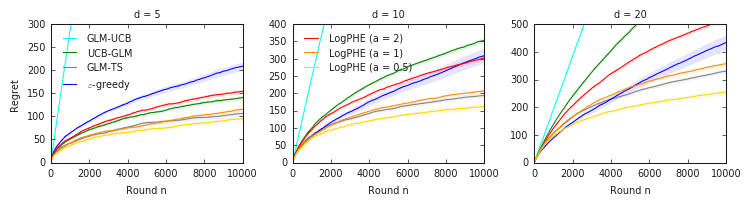

In [0]:
# UAI 2019 experiments
root_dir = "/cns/pw-d/home/bkveton/PHE/UAI2019"

algs = [
  ("LogUCB", {}, "cyan", "-", "GLM-UCB"),
  ("UCBLog", {}, "green", "-", "UCB-GLM"),
  ("LogTS", {}, "gray", "-", "GLM-TS"),
  ("LogGreedy", {}, "blue", "-", "$\\varepsilon$-greedy"),
  ("LogPHE", {"a": 2}, "red", "-", "LogPHE (a = 2)"),
  ("LogPHE", {"a": 1}, "darkorange", "-", "LogPHE (a = 1)"),
  ("LogPHE", {"a": 0.5}, "gold", "-", "LogPHE (a = 0.5)")]
num_runs = 100
n = 10000
K = 100

step = np.arange(1, n + 1)
sube = (step.size // 10) * np.arange(1, 11) - 1

plt.figure(figsize=(7.5, 2))
for fig in range(3):
  if fig == 0:
    d = 5
  elif fig == 1:
    d = 10
  else:
    d = 20

  env = []
  for run in range(num_runs):
    # standard d-dimensional basis (with a bias term)
    basis = np.eye(d)
    basis[:, -1] = 1

    # arm features in a unit (d - 2)-sphere
    X = np.random.randn(K, d - 1)
    X /= np.sqrt(np.square(X).sum(axis=1))[:, np.newaxis]
    X = np.hstack((X, np.ones((K, 1))))  # bias term
    X[: basis.shape[0], :] = basis

    # parameter vector in a (d - 2)-sphere with radius 1.5
    theta = np.random.randn(d - 1)
    theta *= 1.5 / np.sqrt(np.square(theta).sum())
    theta = np.append(theta, [0])

    # create environment
    env.append(LogBandit(X, theta))
    print("%3d: %.2f %.2f | " % (env[-1].best_arm,
      env[-1].mu.min(), env[-1].mu.max()), end="")
    if (run + 1) % 10 == 0:
      print()

  plt.subplot(1, 3, fig + 1)
  alg_num = 0
  for alg in algs:
    alg_class = eval(alg[0])

    fname = "%s/Data/log_d=%d_%d_%s.npy" % \
      (root_dir, d, alg_num, alg[0].lower())
    if not gfile.Exists(fname):
      regret, _ = evaluate(alg_class, alg[1], env, n)
      with gfile.Open(fname, "w") as f:
        np.save(f, regret)
    with gfile.Open(fname, "r") as f:
      regret = np.load(f)

    cum_regret = regret.cumsum(axis=0)
    std_regret = cum_regret.std(axis=1) / np.sqrt(cum_regret.shape[1])
    plt.plot(step, cum_regret.mean(axis=1),
      alg[2], dashes=linestyle2dashes(alg[3]),
      label=alg[4] if alg_num // 4 == fig else None)
    plt.fill_between(step,
      cum_regret.mean(axis=1) - std_regret,
      cum_regret.mean(axis=1) + std_regret,
      color=alg[2], alpha=0.1, linewidth=0)

    alg_num += 1

  plt.title("d = %d" % d)
  plt.xlabel("Round n")
  if not fig:
    plt.ylabel("Regret")
  plt.ylim(0, 500 - 100 * (2 - fig))
  if fig <= 1:
    plt.legend(loc="upper left", frameon=False)

plt.tight_layout()
with gfile.Open("%s/LogPHE.pdf" % root_dir, "w") as f:
  plt.savefig(f, format="pdf", dpi=1200, bbox_inches=0)
plt.show()